# Dia 3

## Objetivo de hoje:

    - Aplicar Stratified k-fold em Ensemble usando elastic net, xgboost regressor, xgboost classifier, svm, lasso e ridge.
  
    - Aplicar cross validation e ver se bate com a saída online

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

# Random params
np.random.seed(0)
cv = 0
random_state = 339

# Plot params
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

# Data
test = pd.read_csv('../test.csv')
dT = pd.read_csv('../train.csv', index_col='id')
dT.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


# Usar scaled ou normal?

In [2]:
scaler = RobustScaler()
scaler.fit(dT)
scaled = pd.DataFrame(scaler.transform(dT))
scaled.index = dT.index
scaled.columns = dT.columns
scaled.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.398829,-2.193763,-0.327143,-0.456602,-0.224247,-4.832418,-0.650819,-0.257313,-0.033984,-0.175655,...,0.102526,0.083219,0.009271,-0.707166,-0.175492,0.340336,-0.236204,-0.639092,1.158863,1.0
1,0.232641,-0.510205,2.618624,0.532415,0.765539,-0.223838,0.136917,-0.361904,1.089995,1.580895,...,-1.793441,2.422424,-0.070317,0.287792,-0.215769,0.726891,-0.108456,-0.282923,-0.404237,0.0
2,1.899488,-2.258153,-0.092457,0.515775,0.764262,0.270914,0.422915,0.151230,-0.159162,2.626482,...,0.377541,-0.442576,-0.074659,0.640358,0.297984,-0.008403,-0.246470,0.126291,-0.141680,1.0
3,1.344737,-2.176972,-0.124045,-0.426776,1.112414,3.853596,-0.662043,-0.064302,-0.137953,-0.197610,...,-0.860998,0.393669,-0.047472,-1.522058,-0.168826,0.012605,-0.252507,0.343792,0.088193,1.0
4,0.563936,0.648803,-0.344923,0.614129,0.099298,-0.014300,0.542506,-0.477975,0.453781,-0.165396,...,0.042364,-0.127872,-0.029628,-0.116392,-0.181562,3.212185,-0.252764,NaN,-0.517300,1.0


In [3]:
scaler2 = RobustScaler()
scaler2.fit(test)
scaledTest = pd.DataFrame(scaler2.transform(test))
scaledTest.index = test.index
scaledTest.columns = test.columns
scaledTest.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,-1.000000,1.634616,0.561752,0.004272,-0.436084,-0.052378,0.627623,-0.432486,-0.610514,-0.162235,...,-0.383685,-0.326644,0.388342,-0.066354,-1.028541,0.724381,0.175916,-0.249091,-0.251687,-0.021828
1,-0.999996,0.852699,-0.088520,0.121197,2.257673,0.025841,-0.432218,-0.281972,0.565520,0.029320,...,0.897850,0.555282,-0.086373,-0.143050,0.964017,0.823502,-0.277487,0.581125,0.701793,-0.411226
2,-0.999992,0.648364,0.322187,-0.135323,-0.348104,-0.185645,0.341130,0.606370,0.058842,-0.034586,...,0.903799,-0.781063,0.456765,-0.186962,-0.369981,0.213317,-0.234555,-0.249589,0.537805,-0.717242
3,-0.999988,-0.781161,0.040195,-0.070395,2.755782,0.225074,0.102602,-0.525471,0.077081,-0.174198,...,0.996623,0.521730,-0.138197,-0.088949,0.041754,0.086445,-0.295288,3.812129,0.605739,-0.309028
4,-0.999984,-0.220881,-2.266582,2.322536,0.805753,0.708786,-0.715612,0.789371,0.295938,-0.162809,...,-0.208226,-0.173941,2.003088,-0.049698,-0.516521,0.360076,0.749738,3.835887,-0.203619,-0.290105


# Definindo funções para ensemble

In [4]:
X = scaled.copy()
y = X.pop('claim')
print(y.head())

scaledTest = scaledTest.fillna(scaledTest.mean())
X= X.fillna(X.mean())
X.head()

id
0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: claim, dtype: float64


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
0,0.398829,-2.193763,-0.327143,-0.456602,-0.224247,-4.832418,-0.650819,-0.257313,-0.033984,-0.175655,...,-0.486366,0.102526,0.083219,0.009271,-0.707166,-0.175492,0.340336,-0.236204,-0.639092,1.158863
1,0.232641,-0.510205,2.618624,0.532415,0.765539,-0.223838,0.136917,-0.361904,1.089995,1.580895,...,1.209618,-1.793441,2.422424,-0.070317,0.287792,-0.215769,0.726891,-0.108456,-0.282923,-0.404237
2,1.899488,-2.258153,-0.092457,0.515775,0.764262,0.270914,0.422915,0.151230,-0.159162,2.626482,...,-0.309892,0.377541,-0.442576,-0.074659,0.640358,0.297984,-0.008403,-0.246470,0.126291,-0.141680
3,1.344737,-2.176972,-0.124045,-0.426776,1.112414,3.853596,-0.662043,-0.064302,-0.137953,-0.197610,...,-0.726817,-0.860998,0.393669,-0.047472,-1.522058,-0.168826,0.012605,-0.252507,0.343792,0.088193
4,0.563936,0.648803,-0.344923,0.614129,0.099298,-0.014300,0.542506,-0.477975,0.453781,-0.165396,...,1.112968,0.042364,-0.127872,-0.029628,-0.116392,-0.181562,3.212185,-0.252764,0.151335,-0.517300


In [5]:
X.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,...,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000,957919.000000
mean,0.001423,-0.245931,0.692813,0.245079,-0.133020,0.151104,0.086749,0.186415,0.421064,0.756631,...,0.077183,-0.225251,0.398628,1.129342,0.076278,0.507572,0.332726,0.561205,0.151335,0.182747
std,0.933928,0.827175,1.580673,0.804452,0.836685,1.031264,0.628445,0.730049,0.749310,1.778081,...,0.579129,0.784650,0.858782,2.304461,0.884537,1.065574,1.197704,1.270564,0.647910,0.862707
min,-5.187582,-2.326933,-2.658043,-0.836300,-1.942892,-6.075907,-0.829496,-0.680755,-0.536169,-4.891511,...,-0.786631,-3.884071,-1.338707,-1.499433,-2.428221,-1.179107,-2.856408,-0.422785,-0.754029,-1.330097
25%,-0.424178,-0.590251,-0.211482,-0.384702,-0.496025,-0.357425,-0.472777,-0.417947,-0.159080,-0.176872,...,-0.471988,-0.589099,-0.165761,-0.118168,-0.464112,-0.196203,-0.314076,-0.247928,-0.391601,-0.411306
50%,0.001423,-0.014082,0.011128,0.014847,-0.014683,0.018902,0.021446,0.015106,0.014328,0.011963,...,0.033712,-0.014647,0.006282,0.004674,0.014264,0.011320,0.011555,0.013966,0.013970,0.014053
75%,0.548376,0.389738,0.756960,0.597183,0.486101,0.628792,0.511032,0.564439,0.823205,0.798993,...,0.506405,0.391364,0.789948,0.976856,0.515176,0.777008,0.660714,0.731892,0.591883,0.567497
max,7.024291,0.740536,9.504418,4.514653,1.317161,5.670167,1.976067,3.460161,3.208628,15.051439,...,1.497316,0.691855,2.806621,11.014965,4.142495,5.887294,7.452731,5.931227,2.053729,4.833727


100%|██████████| 118/118 [12:35<00:00,  6.40s/it]


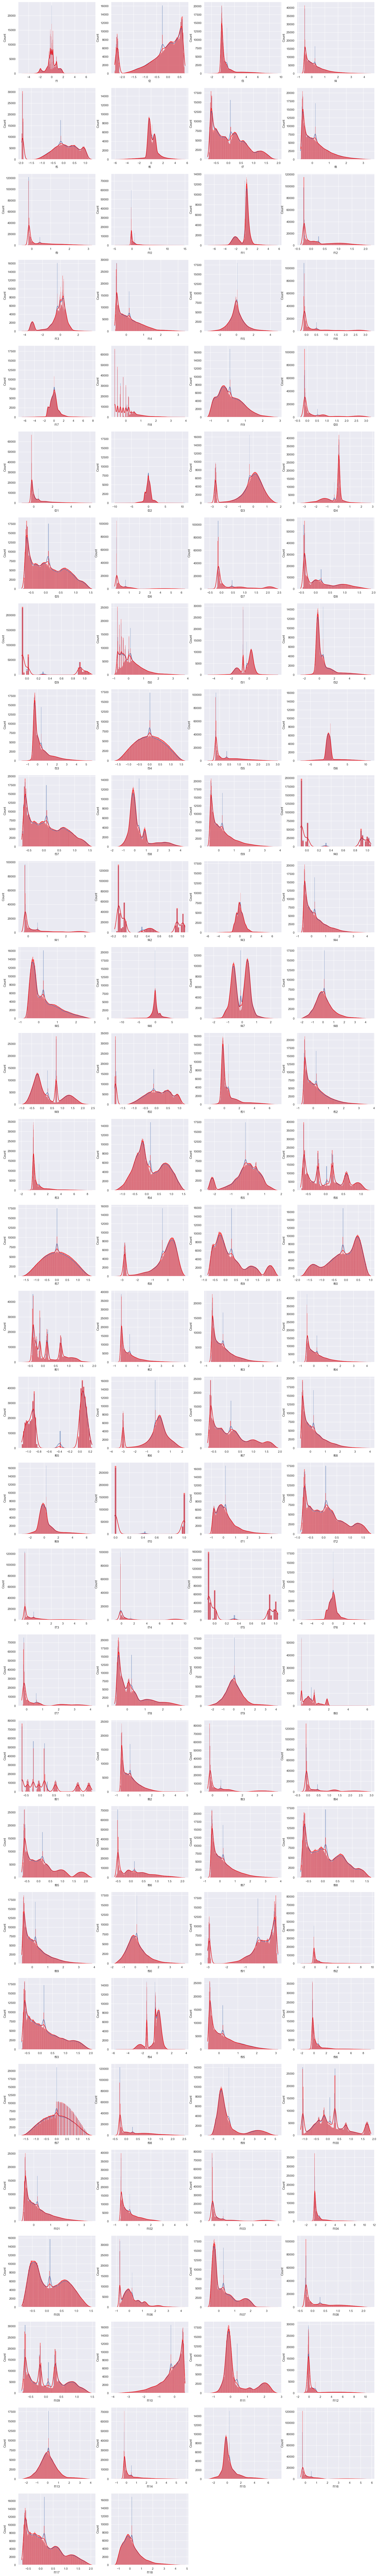

In [6]:
train = X.copy()
train['claim'] = y
uns=train.loc[train['claim']==1]
zerous=train.loc[train['claim']==0]
from tqdm import tqdm
plt.figure(figsize=(24, 6*(118/4)))
for i in tqdm(range(len(train.columns.tolist())-1)):
    plt.subplot(30, 4, i+1)
    sns.histplot(uns[f'f{i+1}'], kde=True)
    sns.histplot(zerous[f'f{i+1}'], kde=True, color='red')
plt.show()

In [40]:
(uns.mode()-zerous.mode()).isnull().sum()

f1       0
f2       0
f3       0
f4       0
f5       0
        ..
f115     0
f116     0
f117     0
f118     0
claim    0
Length: 119, dtype: int64

In [45]:
desc0 = train.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])-zerous.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
desc0 = desc0.transpose()
desc0.head()
# desc['95%']
# print(desc)

,count,mean,std,min,25%,50%,75%,95%,99%,max
f1,477515.0,-0.007293,-0.006880,-0.131178,-0.001642,0.000000,-0.014912,-0.018153,-0.015128,0.246580
f2,477515.0,-0.006758,-0.002240,0.000000,-0.007127,-0.014652,-0.007127,-0.001767,-0.001892,0.000000
f3,477515.0,0.018781,0.004557,-0.008271,0.005395,0.013785,0.015922,0.031545,-0.009476,0.000000
f4,477515.0,0.003419,-0.000584,0.000000,0.003240,0.009999,-0.001183,0.003139,0.003515,0.000000
f5,477515.0,-0.003415,-0.005600,-0.000325,-0.003018,-0.014161,-0.006790,-0.003424,-0.004411,0.001857


In [66]:
feat = 'f11'
(train/train.mean()>1).describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,957919,957919,957919,957919,957919,957919,957919,957919,957919,957919,...,957919,957919,957919,957919,957919,957919,957919,957919,957919,957919
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,488051,588549,708932,583877,555703,537917,516060,560682,597957,711501,...,592953,658675,748196,527157,654661,631646,682590,562243,578175,480404


In [46]:
desc1 = train.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])-uns.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])
desc1['hmm'] = desc1.loc[np.where(desc1['mean']<0)]
desc1 = desc1.transpose()
desc1.head()

,count,mean,std,min,25%,50%,75%,95%,99%,max
f1,480404.0,0.007337,0.007030,0.000000,0.001772,0.000000,0.015344,0.019018,0.015128,0.000000
f2,480404.0,0.006799,0.002314,-0.002292,0.007469,0.014709,0.007184,0.001824,0.001985,0.001026
f3,480404.0,-0.018894,-0.004349,0.000000,-0.005513,-0.014580,-0.016729,-0.030552,0.010388,0.008445
f4,480404.0,-0.003439,0.000602,-0.057696,-0.003698,-0.010152,0.001126,-0.003389,-0.003620,0.105338
f5,480404.0,0.003436,0.005685,0.000000,0.002844,0.015147,0.007196,0.003250,0.004643,0.000000


In [25]:
uns.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,...,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.000000,477515.0
mean,-0.005914,-0.252730,0.711707,0.248518,-0.136456,0.161568,0.091920,0.196809,0.423461,0.764983,...,-0.229653,0.404029,1.116520,0.081770,0.510926,0.332212,0.558214,0.150027,0.186736,1.0
std,0.926898,0.824861,1.585022,0.803850,0.830999,1.023841,0.627140,0.733875,0.748270,1.776936,...,0.784898,0.857662,2.281537,0.883995,1.063633,1.193226,1.262995,0.644540,0.862701,0.0
min,-5.187582,-2.324641,-2.658043,-0.778605,-1.942892,-5.968203,-0.826915,-0.680755,-0.504309,-4.865698,...,-3.884071,-1.338707,-1.362735,-2.406037,-1.109341,-2.856408,-0.422785,-0.754029,-1.330097,1.0
25%,-0.425950,-0.597719,-0.205969,-0.381003,-0.498868,-0.349494,-0.464841,-0.410719,-0.158469,-0.176081,...,-0.591143,-0.162184,-0.116984,-0.457262,-0.194543,-0.311975,-0.247805,-0.389697,-0.406835,1.0
50%,0.001423,-0.028791,0.025708,0.024999,-0.029830,0.035474,0.038772,0.031320,0.023414,0.023517,...,-0.024056,0.012372,0.006121,0.024321,0.018758,0.016807,0.018305,0.020283,0.025040,1.0
75%,0.533032,0.382554,0.773689,0.596057,0.478904,0.631496,0.511330,0.573334,0.820359,0.801788,...,0.387909,0.788208,1.011184,0.516285,0.771586,0.654412,0.718278,0.585922,0.567295,1.0
95%,1.532751,0.622634,4.638509,1.919019,0.957576,1.915516,1.319331,1.693253,2.030822,4.888645,...,0.585799,2.192775,6.802911,1.644339,2.925697,2.876050,3.906107,1.415651,1.897072,1.0
99%,1.899488,0.669498,6.525757,3.049799,1.071557,3.380721,1.594697,2.500112,2.605740,8.219132,...,0.631939,2.442914,8.770232,2.969588,4.409559,4.638655,4.952605,1.740381,3.113084,1.0
max,7.024291,0.739510,9.495972,4.409315,1.317161,5.547776,1.976067,3.460161,3.208628,15.051439,...,0.685196,2.792896,10.918125,4.142495,5.819073,7.327731,5.931227,2.053729,4.833727,1.0


In [26]:
zerous.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,...,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.000000,480404.0
mean,0.008716,-0.239173,0.674032,0.241660,-0.129605,0.140703,0.081610,0.176083,0.418682,0.748330,...,-0.220875,0.393259,1.142086,0.070819,0.504239,0.333237,0.564177,0.152635,0.178782,0.0
std,0.940808,0.829415,1.576115,0.805036,0.842285,1.038486,0.629698,0.726080,0.750335,1.779182,...,0.784380,0.859860,2.326955,0.885042,1.067491,1.202139,1.278037,0.651241,0.862695,0.0
min,-5.056404,-2.326933,-2.649771,-0.836300,-1.942567,-6.075907,-0.829496,-0.677546,-0.536169,-4.891511,...,-3.871723,-1.337876,-1.499433,-2.428221,-1.179107,-2.850000,-0.411035,-0.752514,-1.322346,0.0
25%,-0.422536,-0.583124,-0.216877,-0.387942,-0.493007,-0.365258,-0.480354,-0.424617,-0.159446,-0.177625,...,-0.587141,-0.169240,-0.119410,-0.470937,-0.197635,-0.315126,-0.248053,-0.393402,-0.415735,0.0
50%,0.001423,0.000570,-0.002658,0.004847,-0.000522,0.003187,0.005014,-0.000256,0.005426,0.002572,...,-0.005067,0.000387,0.003186,0.004217,0.004085,0.007353,0.009894,0.007451,0.003087,0.0
75%,0.563287,0.396864,0.741039,0.598366,0.492891,0.626054,0.510734,0.555751,0.826343,0.796020,...,0.394837,0.791712,0.944618,0.514054,0.782180,0.668067,0.745135,0.597802,0.567641,0.0
95%,1.569922,0.626226,4.576413,1.912491,0.964250,1.895535,1.307565,1.654050,2.022273,4.864354,...,0.589355,2.185816,6.896184,1.625426,2.939178,2.897059,3.928559,1.427862,1.889194,0.0
99%,1.929743,0.673375,6.545620,3.042664,1.080611,3.362173,1.582788,2.447699,2.604111,8.210631,...,0.634294,2.440304,8.838076,2.963677,4.393417,4.665966,4.980216,1.747418,3.095411,0.0
max,6.777711,0.740536,9.504418,4.514653,1.315304,5.670167,1.963557,3.448869,3.204100,14.632913,...,0.691855,2.806621,11.014965,4.133038,5.887294,7.452731,5.908584,2.053108,4.802640,0.0


In [ ]:
# import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, LinearRegression,ElasticNet


skf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
skf.get_n_splits(X, y)

final_predictions = []
history = []
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X=X,y=y)):
    X_train = X.loc[train_indicies]
    X_valid = X.loc[valid_indicies]
    X_test = test.copy()
    
    y_train = y.loc[train_indicies]
    y_valid = y.loc[valid_indicies]


    model = LogisticRegression()

    preds_valid = model.predict(X_valid)
    preds_test = model.predict(X_test)
    final_predictions.append(preds_test)
    history.append([fold, roc_auc_score(y_valid, preds_valid)])
    print(history[-1])

NameError: name 'StratifiedKFold' is not defined

In [ ]:
# from sklearn.linear_model import ElasticNetCV

# regr = ElasticNetCV(cv=15, random_state=random_state)
# regr.fit(X, y)
print(history)
# print(max(history,1))
# print(len(history))
# print(history[:][:][0])
maior =0.0
for ii in range(len(history)):
    print(history[ii][1])
    if history[ii][1]>maior:
        maior = history[ii][1]
        print(maior)
        max_index = ii
# max_index = history.index(.max)
print(max_index)
print(history[max_index][1])


[[0, 0.7265515529932685], [1, 0.7284818652267913], [2, 0.7276732431328169], [3, 0.7288973183540997], [4, 0.7262449626986168], [5, 0.7295652713982185], [6, 0.7255525254251636], [7, 0.7261784458154404], [8, 0.7274334470064989], [9, 0.7258445688483475]]
0.7265515529932685
0.7265515529932685
0.7284818652267913
0.7284818652267913
0.7276732431328169
0.7288973183540997
0.7288973183540997
0.7262449626986168
0.7295652713982185
0.7295652713982185
0.7255525254251636
0.7261784458154404
0.7274334470064989
0.7258445688483475
5
0.7295652713982185


In [ ]:
# scores = cross_val_score(regr, X, y, scoring='roc_auc', cv=15, n_jobs=-1)
# print(scores)

In [ ]:
# preds_test = regr.predict(X_test)
# final_predictions.append(preds_test)


In [ ]:
# print(final_predictions)
# print(preds_test)

In [ ]:
sub = final_predictions[:][max_index]

id       1.204656e+08
claim    5.025594e-02
dtype: float64


<AxesSubplot:>

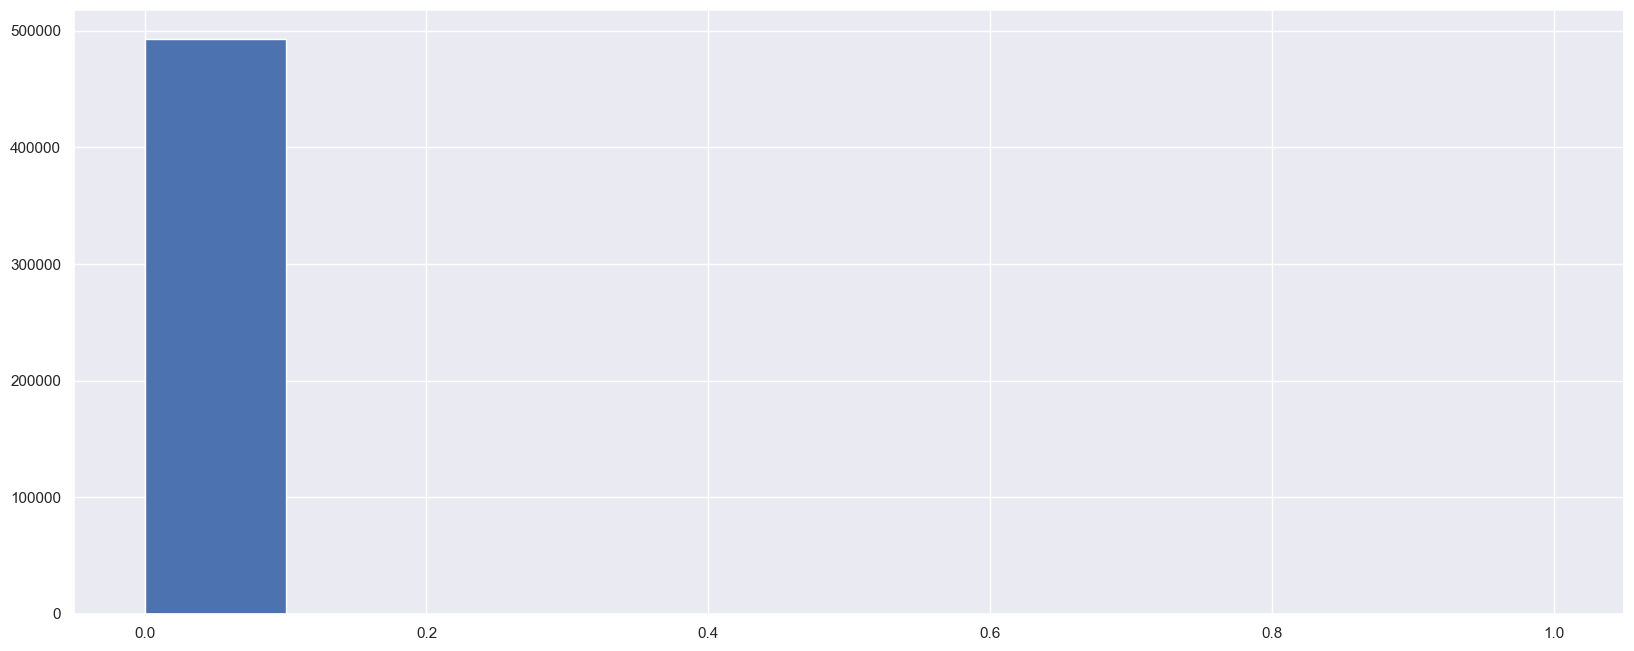

In [ ]:
mysub = pd.DataFrame(test['id'])
mysub['claim'] = sub
mysub['claim'] = mysub['claim'].fillna(0)
print(mysub.mean()*100)
mysub['claim'].hist()

In [ ]:
mysub.head()

,id,claim
0,957919,0.0
1,957920,0.0
2,957921,0.0
3,957922,0.0
4,957923,0.0


In [ ]:
var = 'catboost_meanInputing_ROBUSTscaledInput'
mysub.to_csv(var+'_submisssion.csv',index=False)

# Treinando ensemble

# Vendo resultados:

# Criando submissão: